# Spotting cars using convolutional neural networks

`Group`: PA 5 14

`Date`: 8 Mars 2023

`Group member`: 
- Albin Ekström
- Jonas Nordin

## 1. Initalizing the data
First, set images color values ranging from 0 to 1 instead of 0 to 255. We do this because normalizing the input data to have values between 0 and 1 can help to improve the performance and stability of convolutional neural networks.

In [127]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1.0/255)

Initialize the training and validation generators with a fixed img_size of 64x64 and a batch_size of 32, which is a good balance between computation speed and convergence rate.

We also use the class_mode categorical in order to later in the CNN use a one-hot encoding. Every Ybatch will be represented as an array [1. 0.] or [0. 1.], wherever there's a 1.0 this will be the represented class. For example, [1. 0.] will mean the image is no car.

In [128]:
# Import images
imgdir = 'data'
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Xbatch, Ybatch = train_generator.next()

Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


Take a look at the a image and se if it's a car or not. Plot the shape of the Xbatch, the label and image of the fourth item. 

Shape (32, 64, 64, 3)
Image label [0. 1.]


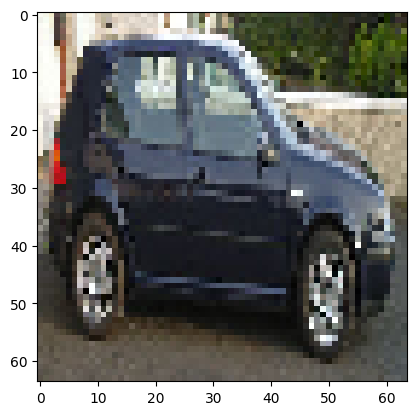

In [129]:
from matplotlib import pyplot as plt

print("Shape", Xbatch.shape) # 32 images in batch, 64x64 images, and 3 colors

print("Image label", Ybatch[4]) # in this case a car

plt.imshow(Xbatch[4])

## 2. Training a convolutional neural network
A CNN is trained using layers such as convolutional, pooling, fully connected, dropout and flatten.

In [130]:
# Implement the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout

def make_convnet(img_size, n_channels):
    input = (img_size[0], img_size[1], n_channels)

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.5)) # add a dropout layer with rate of 0.5
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))
    return model

In [131]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         min_delta=0, patience=2, verbose=0, mode='auto')

In [132]:
# Train CNN
model = make_convnet((64, 64), 3)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs=20, verbose=2, callbacks=[early_stopping])

Epoch 1/20
50/50 - 10s - loss: 0.6708 - accuracy: 0.5981 - val_loss: 0.6258 - val_accuracy: 0.6632 - 10s/epoch - 194ms/step
Epoch 2/20
50/50 - 5s - loss: 0.5794 - accuracy: 0.7056 - val_loss: 0.5900 - val_accuracy: 0.7135 - 5s/epoch - 104ms/step
Epoch 3/20
50/50 - 5s - loss: 0.5208 - accuracy: 0.7563 - val_loss: 0.5235 - val_accuracy: 0.7483 - 5s/epoch - 97ms/step
Epoch 4/20
50/50 - 6s - loss: 0.4888 - accuracy: 0.7775 - val_loss: 0.5289 - val_accuracy: 0.7569 - 6s/epoch - 111ms/step
Epoch 5/20
50/50 - 5s - loss: 0.4551 - accuracy: 0.7906 - val_loss: 0.5297 - val_accuracy: 0.7639 - 5s/epoch - 99ms/step


### Save the weigth from the trained CNN
Save the weight for later use, hence we can use the CNN several times without having to re-train the network.

In [133]:
# Saving the weights from the trained network
model.save_weights('CNN_weights.h5')

### Plotting the loss and accuracy from each epoch

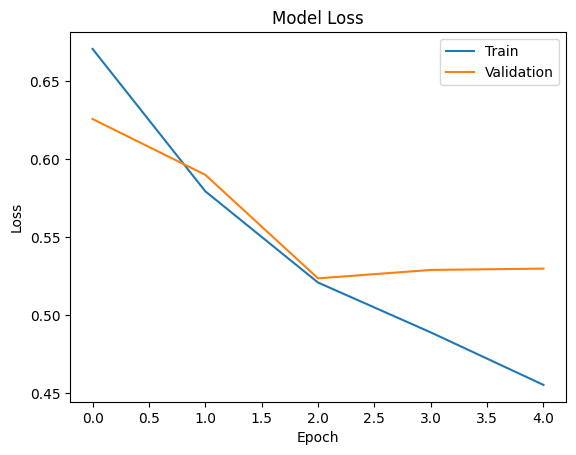

In [134]:
# Plotting the loss for both the training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

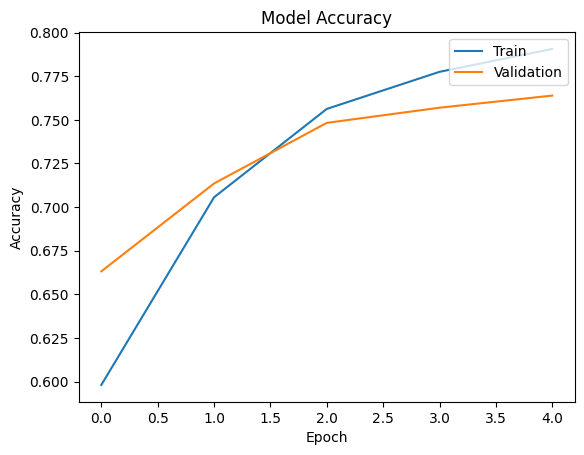

In [135]:
# Plotting the loss for both the training and validation data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Data augmentation
In the first CNN, we used early stopping, hence there wasn't too much overfitting. Anyhow, by using data agumentation the risk of overfitting can be reduced.

In [136]:
# Using data augmentation
augdata_gen = ImageDataGenerator(horizontal_flip=True,
                                 zoom_range=0.2,
                                 rotation_range=20,
                                 rescale=1.0/255)

augtrain_generator = augdata_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [137]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         min_delta=0, patience=4, verbose=0, mode='auto')

## Training model on augmented data

In [138]:
aug_model = make_convnet((64, 64), 3)
aug_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = aug_model.fit(augtrain_generator, validation_data=validation_generator, epochs=20, verbose=2, callbacks=[early_stopping])

Epoch 1/20
50/50 - 8s - loss: 0.6803 - accuracy: 0.5919 - val_loss: 0.6596 - val_accuracy: 0.5885 - 8s/epoch - 152ms/step
Epoch 2/20
50/50 - 6s - loss: 0.6282 - accuracy: 0.6706 - val_loss: 0.5809 - val_accuracy: 0.7118 - 6s/epoch - 128ms/step
Epoch 3/20
50/50 - 7s - loss: 0.5719 - accuracy: 0.7100 - val_loss: 0.5415 - val_accuracy: 0.7292 - 7s/epoch - 139ms/step
Epoch 4/20
50/50 - 7s - loss: 0.5257 - accuracy: 0.7594 - val_loss: 0.5315 - val_accuracy: 0.7378 - 7s/epoch - 149ms/step
Epoch 5/20
50/50 - 9s - loss: 0.5173 - accuracy: 0.7519 - val_loss: 0.5790 - val_accuracy: 0.7465 - 9s/epoch - 181ms/step
Epoch 6/20
50/50 - 7s - loss: 0.5156 - accuracy: 0.7613 - val_loss: 0.5266 - val_accuracy: 0.7448 - 7s/epoch - 141ms/step
Epoch 7/20
50/50 - 7s - loss: 0.5057 - accuracy: 0.7550 - val_loss: 0.5278 - val_accuracy: 0.7431 - 7s/epoch - 141ms/step
Epoch 8/20
50/50 - 6s - loss: 0.4775 - accuracy: 0.7750 - val_loss: 0.4931 - val_accuracy: 0.7569 - 6s/epoch - 121ms/step
Epoch 9/20
50/50 - 6s - 

In [139]:
# Save the model weights
aug_model.save_weights('CNN_aug_weights.h5')

## Visualizing the loss and accuracy 
We see that overfitting is not nearly as big a concern now that the data has been augmented, creating more and more diverse images. The model learned to generalize better by exposing it to a wider range of variations and scenarios.

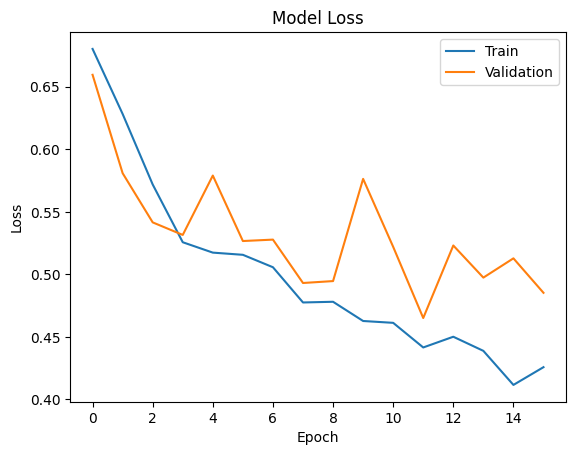

In [140]:
# Plotting the loss for both the training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

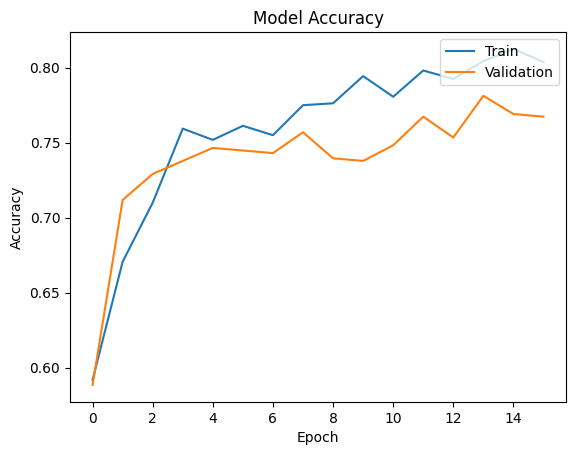

In [141]:
# Plotting the loss for both the training and validation data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## 3. Applying a pre-trained convolutional neural network

In [142]:
# Bypass SSL verification to download the VGG16 model weights from the TensorFlow website
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

In [143]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

### Image preprocessing before VGG-16

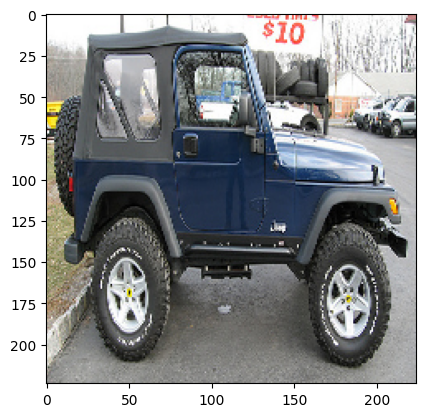

In [144]:
# Initilize the file path
IMAGE_PATH = 'data/validation/car/0000.jpg'

# Load the image
image = load_img(IMAGE_PATH, target_size=(224,224))

# Plot the image
plt.imshow(image)

# Convert image into a 3-dimensional NumPy array
image_array = img_to_array(image)

# Keras preprocessing before VGG-16
image_keras = preprocess_input(image_array)

# Reshape the image to 4-dimensional array
image_keras_array = image_keras.reshape(1, 224, 224, 3)

### Using VGG-16 to predict the image

In [145]:
# Let VGG-16 predict the outcome of the image
prediction = vggmodel.predict(image_keras_array)

# Make the array human understandable
decoded_prediction = decode_predictions(prediction)

1/1 [==============================] - 0s 358ms/step


Looking at the prediction, it makes seens that VGG-16 predicts the image with a 92% certainty it's a jeep followed by the top-3 predictions snowplow and goldcart. Probably the VGG-model isn't trained on predicting only cars, it's trained to predict more specific (e.g. the car company jeep).

In [146]:
print(decoded_prediction[0][0:3])

[('n03594945', 'jeep', 0.9214068), ('n04252225', 'snowplow', 0.024327263), ('n03445924', 'golfcart', 0.014407255)]


## Using VGG-16 as a feature extractor

In [147]:
# Load VGG-16 as a feature extractor
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))

### Image preprocessing

In [148]:
# The preprocess input from Keras is required for the VGG-16 
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

### Function to predict the images using VGG-16 as an extractor

In [149]:
import numpy as np

def create_vgg16_features(generator, directory):

    print("Creating the generator...")
    vgg_train_generator = generator.flow_from_directory(
        imgdir + '/' + directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=False)
    
    print("Prediction initilized...")
    predictions = feature_extractor.predict(vgg_train_generator)
    print("Prediction done!")

    print("Saving the predictions to a Numpy array...")
    with open('cnn_features_' + directory + '.npy', 'wb') as f:
        np.save(f, predictions)

    print("=====> DONE!")

### Function to train and evaluate classifier

In [150]:
from sklearn.linear_model import LogisticRegression

def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

def train_on_cnnfeatures():
    # Load the data
    print("Loading the data...")
    with open('cnn_features_train.npy', 'rb') as f:
        train = np.load(f)
    
    with open('cnn_features_train.npy', 'rb') as f:
        validation = np.load(f)

    # Reshape the data from (1600, 2, 2, 512) to (1600, 2048)
    print("Reshaping the data...")
    new_train_shape = (train.shape[0], np.prod(train.shape[1:]))
    new_val_shape = (validation.shape[0], np.prod(validation.shape[1:]))

    Xtrain = train.reshape(new_train_shape)
    Xval = train.reshape(new_val_shape)

    # Get the labels
    Ytrain = get_labels(len(Xtrain))
    Yval = get_labels(len(Xval))

    # Initilizing and training the classifier
    print("Training and evaluating classifier...")
    clf = LogisticRegression()
    clf.fit(Xtrain, Ytrain)

    # Evaluating the classifier
    Ypred = clf.predict(Xval)
    print("=====> DONE!")

    return Yval, Ypred


### Extract images using VGG-16, classifying using a classifier from Scikit-learn, and then evaluating

In [151]:
# Extract images using VGG-16
create_vgg16_features(vgg_data_gen, 'train')
create_vgg16_features(vgg_data_gen, 'validation')

Creating the generator...
Found 1600 images belonging to 2 classes.
Prediction initilized...
50/50 [==============================] - 23s 459ms/step
Prediction done!
Saving the predictions to a Numpy array...
=====> DONE!
Creating the generator...
Found 576 images belonging to 2 classes.
Prediction initilized...
18/18 [==============================] - 8s 447ms/step
Prediction done!
Saving the predictions to a Numpy array...
=====> DONE!


In [152]:
true, pred = train_on_cnnfeatures()

Loading the data...
Reshaping the data...
Training and evaluating classifier...
=====> DONE!


/Users/albinekstrom/Documents/Chalmers/Läsår 4/LP3/DAT341 - Applied machine learning/GitHub/DAT341-Applied-Machine-Learning/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training a logistic regressor on the extracted features from the VGG-16 model the recevied accruacy is 1.0. As seen below also the recall and precision is 1.0, hence also the f1-score is 1.0, which tells us that all the predicted instances are classified correctly. We also know that the validation data is balanced, thus no biased toward a class.

In section 3 the VGG-16 predicted with 92% centainty that the image was a Jeep. Probably the VGG-16 is absolutely certain that the image represents a car and therefore divides the images containing a car or not into two very easily, for a logistic regressor, identified groups. Therefore, with the help of a logistic regressor, we can classify the images with a 100% certainty.

In [153]:
from sklearn.metrics import classification_report

print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



## 4. Visualizing the learned features
For the enabling layer, the positive values in the kernel suggest that the kernel is detecting edges or gradients in the input image, while the negative values suggest that the kernel is suppressing some features or patterns that are not relevant to the task.

For the disabling layer, the positive values suggest that the kernel is suppressing some features or patterns that are not relevant to the task, while the negative values suggest that the kernel is detecting edges or gradients in the input image.

In [154]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [155]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

## Kernels from VVG-16

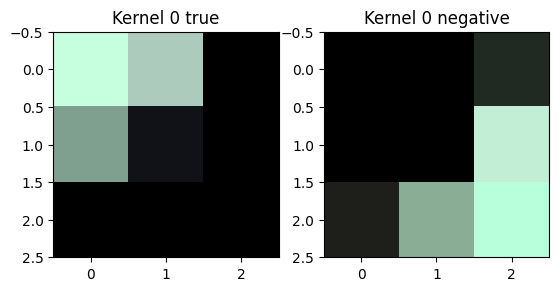

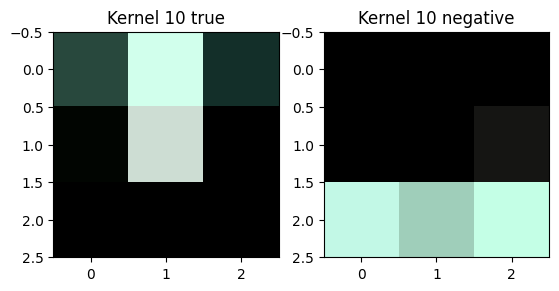

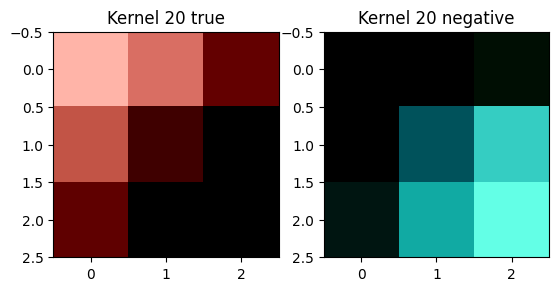

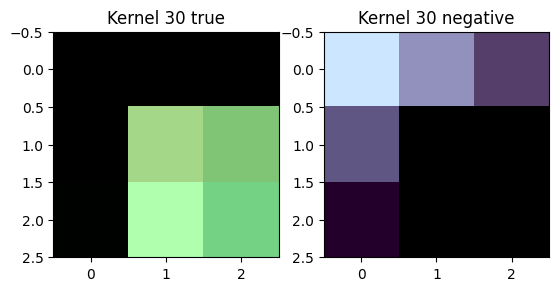

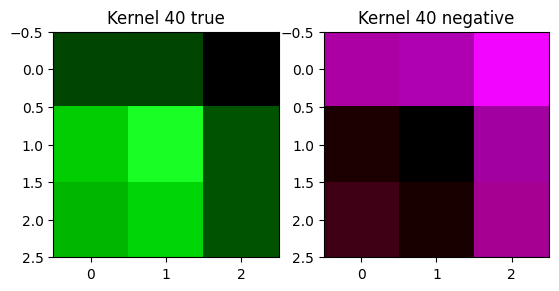

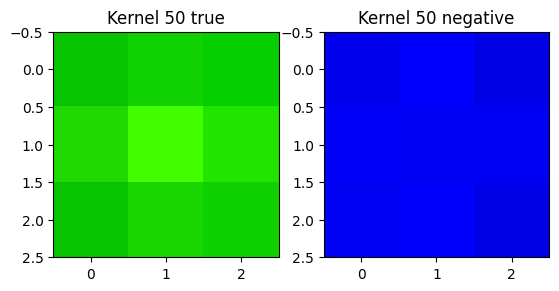

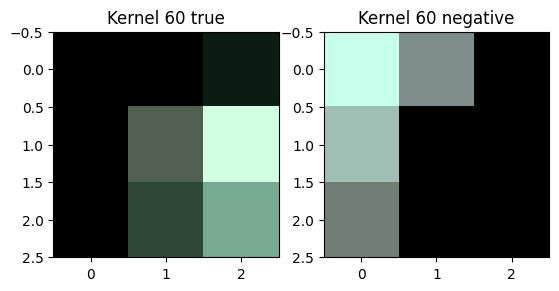

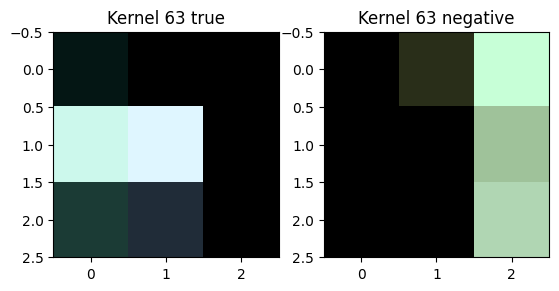

In [156]:
# Visualize several kernel patterns from the first conv layer in VGG-16
layers = [0, 10, 20, 30, 40, 50, 60, 63]

for i in layers:
    true_kernel = kernel_image(first_layer_weights, i, positive=True)
    neg_kernel = kernel_image(first_layer_weights, i, positive=False)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title(f'Kernel {i} true')
    ax2.set_title(f'Kernel {i} negative')

    ax1.imshow(true_kernel)
    ax2.imshow(neg_kernel)

    plt.show()

## Kernels from our own CNN model with augumented data

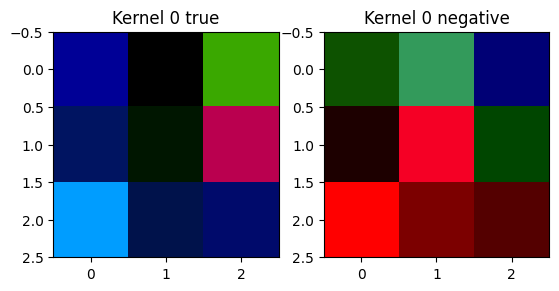

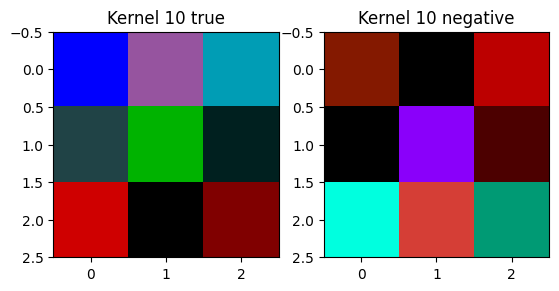

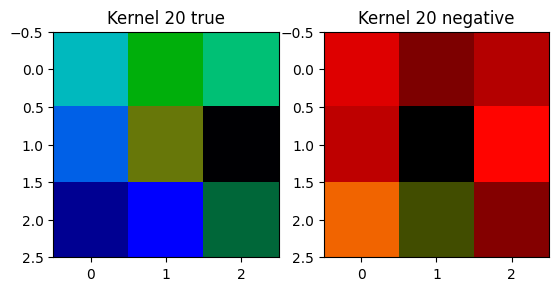

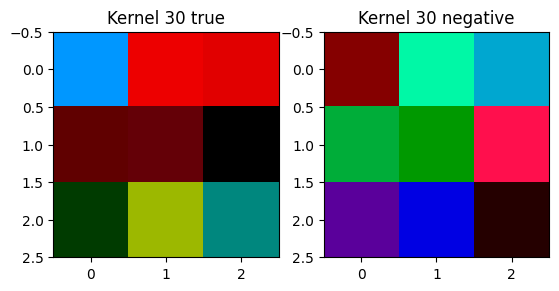

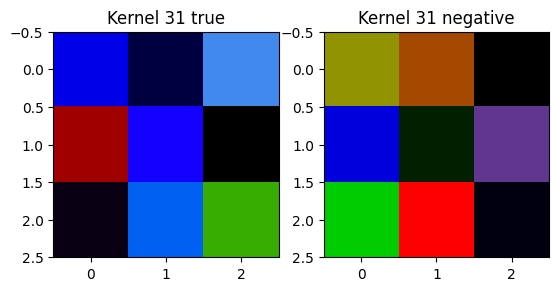

In [157]:
# 
first_aug_layer_weights = aug_model.get_weights()[0]

layers = [0, 10, 20, 30, 31]

for i in layers:
    true_kernel = kernel_image(first_aug_layer_weights, i, positive=True)
    neg_kernel = kernel_image(first_aug_layer_weights, i, positive=False)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title(f'Kernel {i} true')
    ax2.set_title(f'Kernel {i} negative')

    ax1.imshow(true_kernel)
    ax2.imshow(neg_kernel)

    plt.show()

## Visualization of the kernel

1/1 [==============================] - 0s 294ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


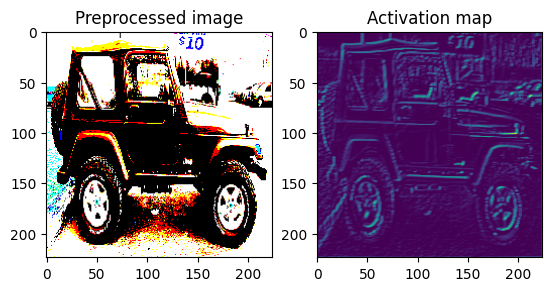

In [158]:
import tensorflow as tf
import scipy.signal

# Extract the output feature maps from the first convolutional layer
layer_outputs = [layer.output for layer in vggmodel.layers if 'conv1' in layer.name]
activation_model = tf.keras.models.Model(inputs=vggmodel.inputs, outputs=layer_outputs)
activations = activation_model.predict(image_keras[np.newaxis, ...])

# Choose one of the convolutional kernels from the layer
first_layer_weights = vggmodel.get_weights()[0]
kernel = kernel_image(first_layer_weights, 10, positive=True)

# Apply the kernel to the feature map
feature_map = activations[0][..., 0]
activation_map = scipy.signal.convolve(feature_map, kernel, mode='same')

# Visualize the activation map by overlaying it on top of the original image
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Preprocessed image')
ax2.set_title('Activation map')

ax1.imshow(image_keras)
ax2.imshow(activation_map[0])

plt.show()